## Feature selection

Hybrid method: Recursive feature elimination
This method consists of the following steps:

Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

it derives the importance derived from the machine learning algorithm, like embedded methods

it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, RecursiveFeatureElimination

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_M")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826.0,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792.0,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964.0,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184.0,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419.0,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [8]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((947, 22), (407, 22))

In [9]:
model = GradientBoostingClassifier(random_state=42,)

# Define cross-validation strategy
scv = StratifiedKFold(n_splits=5, 
                      shuffle=True, 
                      random_state=42)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    estimator=model,
    scoring="roc_auc_ovr_weighted",
    threshold=0.0005,
    cv=scv
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train_t, y_train)

RecursiveFeatureElimination(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                            estimator=GradientBoostingClassifier(random_state=42),
                            scoring='roc_auc_ovr_weighted', threshold=0.0005)

In [10]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.8860349115491488)

In [11]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'Gender': np.float64(0.00022442916106057975),
 'Hip Clusterhade': np.float64(0.0008315775776276402),
 'ERC ASM': np.float64(0.0009256253776326329),
 'ERC CORRELATION': np.float64(0.0002078818716864106),
 'ERC SUM AVERAGE': np.float64(-0.002701311355758018),
 'Hip ASM': np.float64(0.0030129738062245615),
 'ERC SUM VARIANCE': np.float64(0.002420611692538266),
 'ERC VARIANCE ': np.float64(0.0015101523867349087),
 'Hip Variance ': np.float64(0.0012810631718261911),
 'Hip Sum Variance': np.float64(0.00032455338989823),
 'Hip Correlation': np.float64(-0.003925142172005458),
 'ERC CLUSTER SHADE': np.float64(0.0023174161570028717),
 'Hip Sum Average': np.float64(0.0013260807811515951),
 'Hip Contrast': np.float64(-0.0023668838736486952),
 'Age': np.float64(0.004636790238111366),
 'ERC CONTRAST': np.float64(-0.0007339699041772896),
 'ERC ENTROPY': np.float64(0.004717212669314685),
 'ERCs_thicknessbaseline': np.float64(0.0029350982884741583),
 'ERCsVolumebaseline': np.float64(0.0039184813880581

In [12]:
sel.feature_importances_

Gender                      0.006066
Hip Clusterhade             0.013570
ERC ASM                     0.013691
ERC CORRELATION             0.016148
ERC SUM AVERAGE             0.016440
Hip ASM                     0.016620
ERC SUM VARIANCE            0.017890
ERC VARIANCE                0.019346
Hip Variance                0.021064
Hip Sum Variance            0.021222
Hip Correlation             0.021396
ERC CLUSTER SHADE           0.021624
Hip Sum Average             0.023237
Hip Contrast                0.025800
Age                         0.026240
ERC CONTRAST                0.027364
ERC ENTROPY                 0.036599
ERCs_thicknessbaseline      0.051917
ERCsVolumebaseline          0.057877
Hip Entropy                 0.070190
TOTAL_HIPPOCAMPUS_VOLUME    0.071356
MMSE                        0.404345
dtype: float64

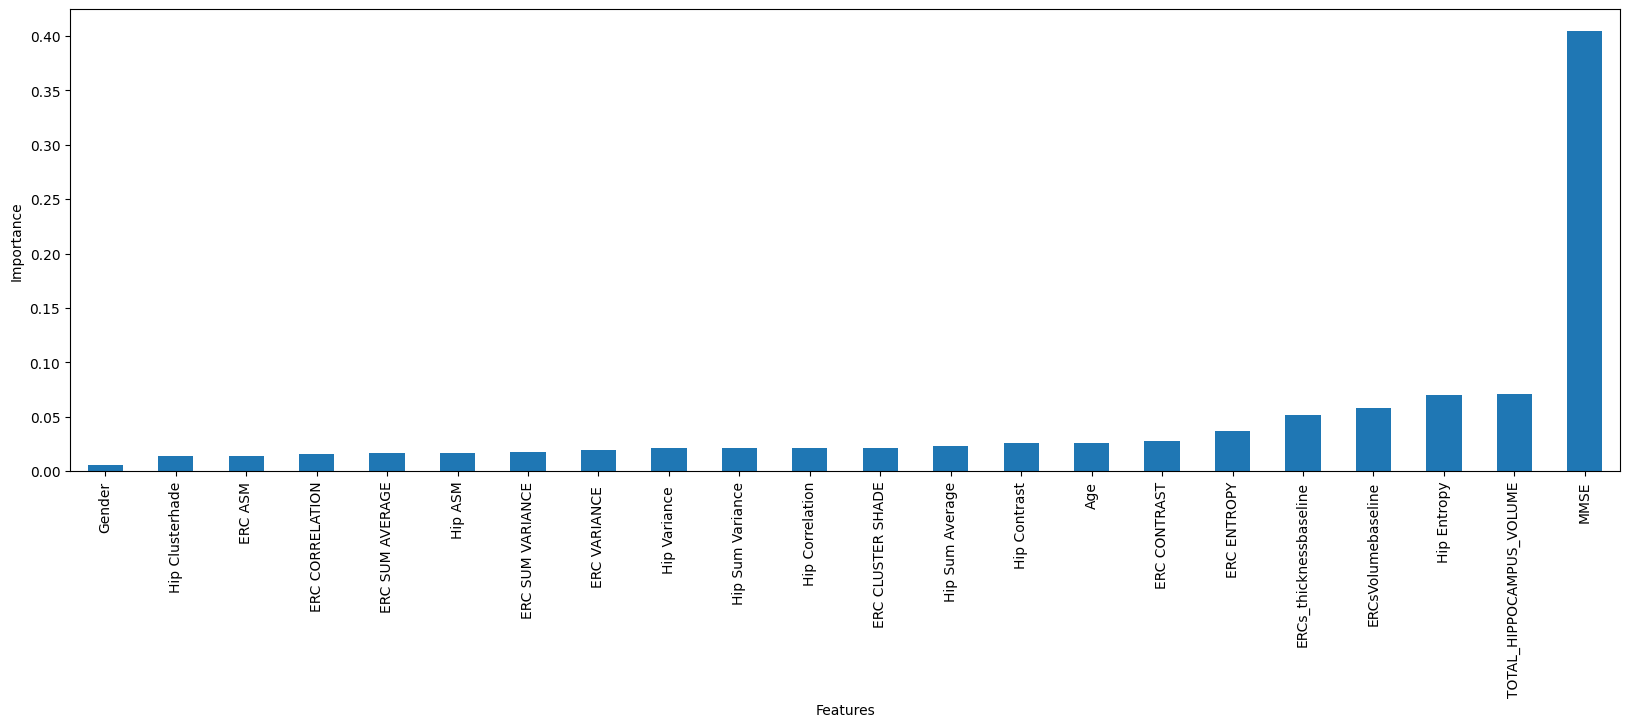

In [13]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

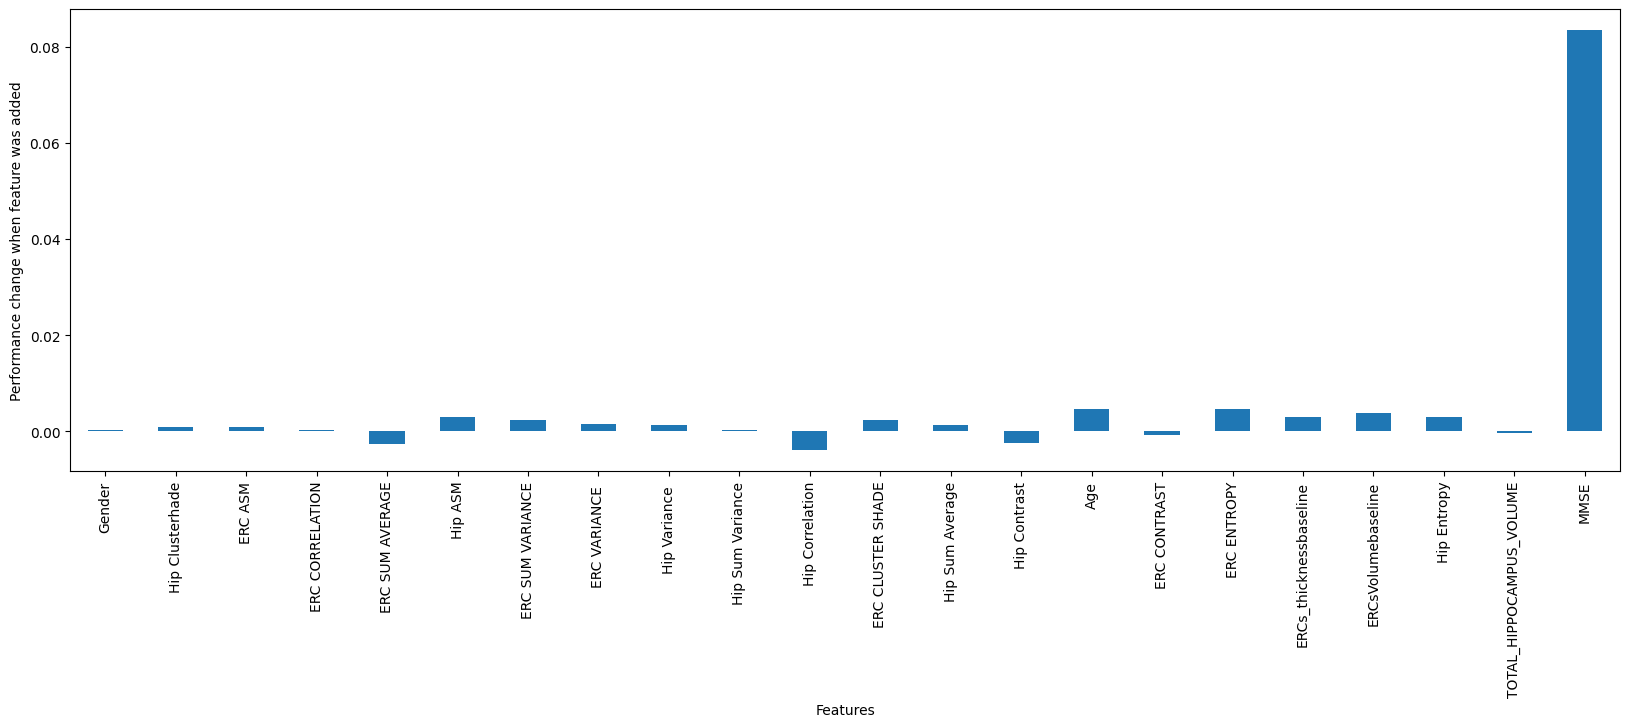

In [14]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [15]:
# Number of features that will be removed

sel.features_to_drop_

['Gender',
 'Hip Contrast',
 'Hip Correlation',
 'Hip Sum Variance',
 'ERC CONTRAST',
 'ERC CORRELATION',
 'ERC SUM AVERAGE',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [16]:
# select features
X_train_t = sel.transform(X_train_knn_t)
X_test_t = sel.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((947, 14), (407, 14))

## Classification Test

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
                
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [18]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

In [19]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.709    22                   0.767   
                                                        0.342    14                   0.759   
                  XGBoost             balanced_accuracy 0.980    22                   1.000   
                                                        0.677    14                   1.000   
                  NGBoost             balanced_accuracy 3.241    22                   0.600   
                                                        2.306    14                   0.567   
                  Logistic Regression balanced_accuracy 0.045    22                   0.630   
                                                        0.024    14                   0.618   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.709    22                  0.006   
                                                        0.342    14                  0.009   
                  XGBoost             balanced_accuracy 0.980    22                  0.000   
                                                        0.677    14                  0.000   
                  NGBoost             balanced_accuracy 3.241    22                  0.008   
                                                        2.306    14                  0.011   
                  Logistic Regression balanced_accuracy 0.045    22                  0.013   
                                                        0.024    14                  0.005   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.709    22                  0.598   
                                                        0.342    14                  0.592   
                  XGBoost             balanced_accuracy 0.980    22                  0.532   
                                                        0.677    14                  0.541   
                  NGBoost             balanced_accuracy 3.241    22                  0.502   
                                                        2.306    14                  0.524   
                  Logistic Regression balanced_accuracy 0.045    22                  0.561   
                                                        0.024    14                  0.562   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.709    22                 0.039  
                                                        0.342    14                 0.040  
                  XGBoost             balanced_accuracy 0.980    22                 0.050  
                                                        0.677    14                 0.046  
                  NGBoost             balanced_accuracy 3.241    22                 0.041  
                                                        2.306    14                 0.030  
                  Logistic Regression balanced_accuracy 0.045    22                 0.053  
                                                        0.024    14                 0.055

In [20]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)
        
        if classifier_name == "Logistic Regression":  
                # Scale features
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [21]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                             
Boruta            Random Forest       0.180               22             accuracy                   0.740   
                                                                         balanced_accuracy          0.763   
                                                                         precision                  0.785   
                                                                         recall                     0.740   
                                                                         f1_weighted                0.752   
                                                                         roc_auc_ovr_weighted       0.942   
                                      0.283               14             accuracy                   0.742   
                                                                         balanced_accuracy          0.755   
                                                                         precision                  0.784   
                                                                         recall                     0.742   
                                                                         f1_weighted                0.754   
                                                                         roc_auc_ovr_weighted       0.936   
                  XGBoost             0.278               22             accuracy                   1.000   
                                                                         balanced_accuracy          1.000   
                                                                         precision                  1.000   
                                                                         recall                     1.000   
                                                                         f1_weighted                1.000   
                                                                         roc_auc_ovr_weighted       1.000   
                                      0.168               14             accuracy                   1.000   
                                                                         balanced_accuracy          1.000   
                                                                         precision                  1.000   
                                                                         recall                     1.000   
                                                                         f1_weighted                1.000   
                                                                         roc_auc_ovr_weighted       1.000   
                  NGBoost             0.685               22             accuracy                   0.772   
                                                                         balanced_accuracy          0.590   
                                                                         precision                  0.771   
                                                                         recall                     0.772   
                                                                         f1_weighted                0.750   
                                                                         roc_auc_ovr_weighted       0.948   
                                      0.460               14             accuracy                   0.758   
                                                                         balanced_accuracy          0.560   
                                                                         precision                  0.748   
                                                                         recall                     0.758   
                                                                         f1_weighted                0.731   
                                                              